<a href="https://github.com/PtPrashantTripathi/PortfolioTracker/blob/main/NOTEBOOKS/05_PRESENTATION_LAYER/01_Trands.ipynb"><svg height="100px" viewBox="0 0 367.4 90"><g><rect width="367.4" height="90" style="fill: #fff;"></rect><path style="fill: #1B1F24;" d="M46.1,0C20.6,0,0,20.6,0,46.1c0,20.4,13.2,37.7,31.5,43.8c2.3,0.4,3.2-1,3.2-2.2c0-1.1-0.1-4.7-0.1-8.6,c-11.6,2.1-14.6-2.8-15.5-5.4c-0.5-1.3-2.8-5.4-4.7-6.5c-1.6-0.9-3.9-3-0.1-3.1c3.6-0.1,6.2,3.3,7.1,4.7c4.2,7,10.8,5,13.4,3.8,c0.4-3,1.6-5,2.9-6.2c-10.3-1.2-21-5.1-21-22.8c0-5,1.8-9.2,4.7-12.4c-0.5-1.2-2.1-5.9,0.5-12.2c0,0,3.9-1.2,12.7,4.7,c3.7-1,7.6-1.6,11.5-1.6c3.9,0,7.8,0.5,11.5,1.6c8.8-6,12.7-4.7,12.7-4.7c2.5,6.3,0.9,11.1,0.5,12.2c2.9,3.2,4.7,7.3,4.7,12.4,c0,17.7-10.8,21.6-21.1,22.8c1.7,1.4,3.1,4.2,3.1,8.5c0,6.2-0.1,11.1-0.1,12.7c0,1.2,0.9,2.7,3.2,2.2c18.2-6.1,31.4-23.4,31.4-43.8,C92.3,20.6,71.6,0,46.1,0z M221.6,67.1h-0.1C221.6,67.1,221.6,67.1,221.6,67.1L221.6,67.1L221.6,67.1z M221.6,67.1,c-0.5,0-1.8,0.3-3.2,0.3c-4.4,0-5.9-2-5.9-4.6V45.3h8.9c0.5,0,0.9-0.4,0.9-1.1v-9.5c0-0.5-0.4-0.9-0.9-0.9h-8.9V22.1,c0-0.4-0.3-0.7-0.8-0.7h-12c-0.5,0-0.8,0.3-0.8,0.7v12.1c0,0-6.1,1.5-6.5,1.6c-0.4,0.1-0.7,0.5-0.7,0.9v7.6c0,0.6,0.4,1.1,0.9,1.1,h6.2v18.3c0,13.6,9.5,15,16,15c3,0,6.5-0.9,7.1-1.2c0.3-0.1,0.5-0.5,0.5-0.9v-8.4C222.5,67.6,222.1,67.2,221.6,67.1z M353.8,54.9,c0-10.1-4.1-11.4-8.4-11c-3.3,0.2-6,1.9-6,1.9v19.6c0,0,2.7,1.9,6.8,2C352,67.6,353.8,65.5,353.8,54.9z M367.4,54,c0,19.1-6.2,24.6-17,24.6c-9.1,0-14.1-4.6-14.1-4.6s-0.2,2.6-0.5,2.9c-0.2,0.3-0.4,0.4-0.8,0.4h-8.3c-0.6,0-1.1-0.4-1.1-0.9l0.1-62,c0-0.5,0.4-0.9,0.9-0.9h11.9c0.5,0,0.9,0.4,0.9,0.9l-0.1,20.9c0,0,4.6-3,11.3-3h0.1C357.5,32.3,367.4,34.8,367.4,54z M318.7,33.8,H307c-0.6,0-0.9,0.4-0.9,1.1v30.3c0,0-3.1,2.2-7.3,2.2c-4.2,0-5.4-1.9-5.4-6.1V34.8c0-0.5-0.4-0.9-0.9-0.9h-11.9,c-0.5,0-0.9,0.4-0.9,0.9v28.5c0,12.3,6.9,15.3,16.3,15.3c7.8,0,14.1-4.3,14.1-4.3s0.3,2.2,0.4,2.5c0.1,0.3,0.5,0.5,0.9,0.5h7.5,c0.6,0,0.9-0.4,0.9-0.9l0.1-41.7C319.8,34.3,319.3,33.8,318.7,33.8z M186.5,33.8h-11.9c-0.5,0-0.9,0.5-0.9,1.1v40.9,c0,1.1,0.7,1.5,1.7,1.5h10.7c1.1,0,1.4-0.5,1.4-1.5V34.7C187.5,34.2,187,33.8,186.5,33.8z M180.7,14.9c-4.3,0-7.7,3.4-7.7,7.7,s3.4,7.7,7.7,7.7c4.2,0,7.6-3.4,7.6-7.7S184.9,14.9,180.7,14.9z M272.7,13.5h-11.8c-0.5,0-0.9,0.4-0.9,0.9v22.8h-18.5V14.5,c0-0.5-0.4-0.9-0.9-0.9h-11.9c-0.5,0-0.9,0.4-0.9,0.9v62c0,0.5,0.5,0.9,0.9,0.9h11.9c0.5,0,0.9-0.4,0.9-0.9V49.9h18.5l-0.1,26.5,c0,0.5,0.4,0.9,0.9,0.9h11.9c0.5,0,0.9-0.4,0.9-0.9v-62C273.6,14,273.2,13.5,272.7,13.5z M167.4,41v32c0,0.2-0.1,0.6-0.3,0.7,c0,0-7,5-18.5,5c-13.9,0-30.3-4.4-30.3-33c0-28.7,14.4-34.6,28.4-34.5c12.2,0,17.1,2.7,17.8,3.2c0.2,0.3,0.3,0.5,0.3,0.8l-2.3,9.9,c0,0.5-0.5,1.1-1.1,0.9c-2-0.6-5-1.8-12.1-1.8c-8.2,0-17,2.3-17,20.8s8.4,20.6,14.4,20.6c5.1,0,7-0.6,7-0.6V52.2h-8.2,c-0.6,0-1.1-0.4-1.1-0.9V41c0-0.5,0.4-0.9,1.1-0.9h20.9C167,40,167.4,40.5,167.4,41z"/></g></svg></a>

In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from StockETL import GlobalPath

In [2]:
# Import necessary utility functions
%run ../COMMON/common_utility.ipynb

In [3]:
# Ignore harmless warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore", ConvergenceWarning)

### Step 1: Load and Prepare Data


In [4]:
# Load and Prepare Data
holding_gold_file_path = GlobalPath("DATA/GOLD/Holding/Holding_data.csv")
df = pd.read_csv(holding_gold_file_path)

# Convert datetime column to date and process data
df["date"] = pd.to_datetime(df["date"])
df = df.groupby("date").sum().reset_index()

# Sort data by date and reset index
df = df.sort_values(by="date").reset_index(drop=True)

# Calculate Moving Average
df["moving_avg"] = df["high_amount"].rolling(window=52).mean()

# Set the 'date' column as the index
df.set_index("date", inplace=True)

df = df[["high_amount", "moving_avg"]]
# Fix Frequency Warning: Set frequency explicitly
df = df.asfreq("D")

### Step 2: Prepare Forecasting Models

In [5]:
# Model : Holt-Winters (Triple Exponential Smoothing)
holt_winters_model = ExponentialSmoothing(
    df["high_amount"],
    trend="add",
    seasonal="add",
    seasonal_periods=52,
    initialization_method="estimated",
)
hw_fit = holt_winters_model.fit(optimized=True, remove_bias=True)
predictions_hw = hw_fit.forecast(steps=365)
forecast_hw = pd.DataFrame(data=predictions_hw, columns=["forcast"])
hw_fit.summary()

Dep. Variable:,high_amount,No. Observations:,139
Model:,ExponentialSmoothing,SSE,1331891898.227
Optimized:,True,AIC,2346.480
Trend:,Additive,BIC,2510.810
Seasonal:,Additive,AICC,2432.030
Seasonal Periods:,52,Date:,"Wed, 09 Oct 2024"
Box-Cox:,False,Time:,19:54:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0001,beta,True


### Step 3: Combine Forecasts


In [6]:
# Combine forecasts into a single DataFrame
df = pd.concat([df, forecast_hw], axis=1)
df.to_csv("all_forecasts.csv")

### Step 4: Plot the Results


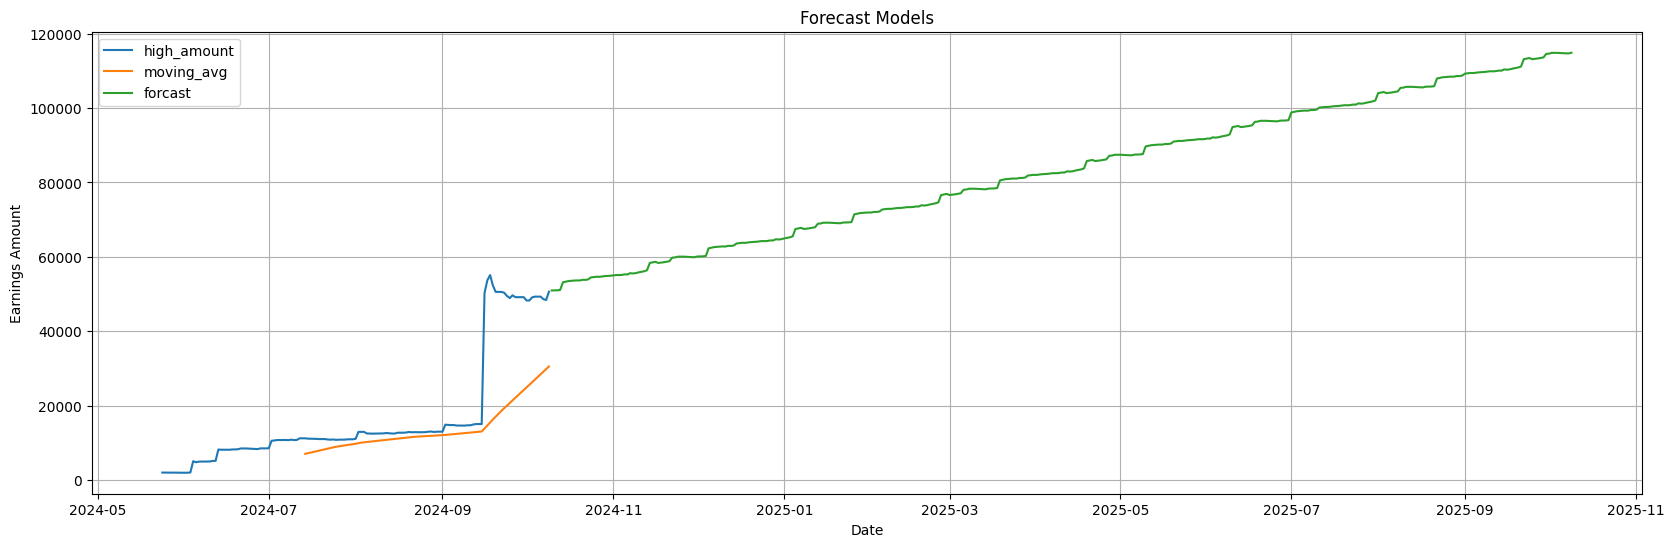

In [7]:
# Plot all forecasts and actual data
plt.figure(figsize=(20, 6))

# Plot actual data
plt.plot(df)

# Customize plot
plt.title("Forecast Models")
plt.xlabel("Date")
plt.ylabel("Earnings Amount")
plt.legend(df.columns)
plt.grid(True)
plt.show()